# Hyperparameters and Model Validation
Follow _Data Science Handbook_ Ch. 5 [Hyperparameters and Model Validation](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.03-Hyperparameters-and-Model-Validation.ipynb) (p.359-373)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Model validation the wrong way

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

In [3]:
print(X.shape)
type(X)

(150, 4)


numpy.ndarray

In [4]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=1)
model.fit(X,y)
y_pred = model.predict(X)

In [5]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_pred)

1.0

We achieve perfection!

**Question:** How could a model achieve perfection?

**Answer:** Memorize all the data.

### Model validation the right way: Holdout/validation set 
We will only use 50% of the data to train, and keep the other 50% as unseen data to evaluate the model.

In [6]:
from sklearn.model_selection import train_test_split

X1, X2, y1, y2 = train_test_split(X, y, random_state=0, train_size=0.5)

model.fit(X1, y1)
y2_pred = model.predict(X2)
accuracy_score(y2, y2_pred)

0.9066666666666666

We can do this twice, switching the splits (see Fig 5-22 in the book)

In [7]:
y2_pred = model.fit(X1, y1).predict(X2)
y1_pred = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_pred), accuracy_score(y2, y2_pred)

(0.96, 0.9066666666666666)

### Cross-validation
Instead of two folds (above), we can split the data into five folds. Then use four to train and one to validate. Iterate this five times:

![](05.03-5-fold-CV.png)

In [8]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5)
scores

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

In [9]:
scores.mean()

0.96

We are training the model five times with different data, evaluate it on data it has not seen during training. On average, we get 96% accuracy.

Cross-validation is used to measure how well a given algorithm generalizes.

Besides training and validation sets, there is the test set. The test set is used at the end of model selection and hyperparameter tuning, prior to *shipping it to the customer*.

**Question:** Change the code to run 3-fold cross-validation. What are the scores and their average?

In [10]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=3)
scores

array([0.98, 0.94, 0.96])

In [11]:
scores.mean()

0.96

## Selecting the best model
### Bias-variance tradeoff
- For high-bias models (_underfitting_), the performance of the model on the validation set is similar to the performance on the training set.
- For high-variance models (_overfitting_), the performance of the model on the validation set is far worse than the performance on the training set.

**Side note:** If the model makes _many_ mistakes on the training data we say the model _underfits_, has _high bias_. If the model makes _few_ mistakes on the training data we say the model has _low bias_. Similarly, _overfitting_ is termed _high variance_, training and validation/test scores are _very different_. _low variance_ would indicate that training and validation scores are _similar_.

The **validation curve** (Figure 5-26)  

![](05.03-validation-curve.png)

- The training score is everywhere higher than the validation score. This is generally the case: the model will be a better fit to data it has seen than to data it has not seen.
- For very low model complexity (a high-bias model), the training data is under-fit, which means that the model is a poor predictor both for the training data and for any previously unseen data.
- For very high model complexity (a high-variance model), the training data is over-fit, which means that the model predicts the training data very well, but fails for any previously unseen data.
- For some intermediate value, the validation curve has a maximum. This level of complexity indicates a suitable trade-off between bias and variance.

### Validation curves in scikit-learn 

To demonstrate validation curves, we need some data, a model, and a way to tune the models complexity.

One example is using linear regression with a polynomial feature generation, effectlively turning straight lines into polynomials of various degrees.

In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [13]:
def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

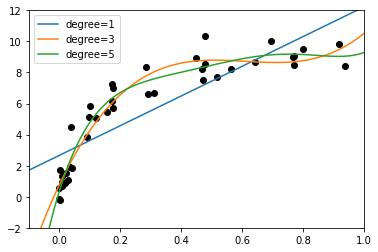

In [14]:
%matplotlib inline

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

**Question:** Which of the three models above is the most complex? Which model results in the best training score?

**Answer:** degree5 is most complex and is expected to perform best training score.

### Using `validation_curve()` 

To assess the effect of training and validation scores, we can sweep the degree of the polynomial model, make it more complex, and measure the two scores.

`validation_curve()` does all that for us, including splitting the data into training and validation sets repeatedly using cross-validation.

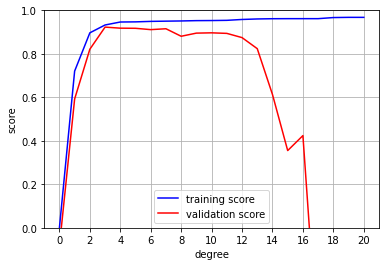

In [16]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          param_name='polynomialfeatures__degree', 
                                          param_range=degree, 
                                          cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xticks(ticks=degree[::2])
plt.xlabel('degree')
plt.ylabel('score');
plt.grid(True)

We see that a degree 3 polynomial provides an optimal tradeoff between bias and variance:
- Training and validation scores are very similar (low variance)
- Training score is relatively high, close to 1.0, few mistakes (low bias).

Another observation: If we see high variance, we might need to decrease model complexity.

### If only we had more data 

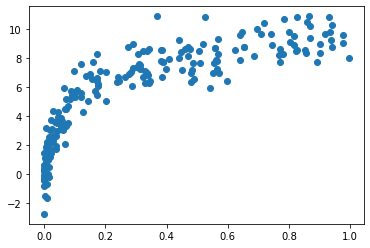

In [17]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

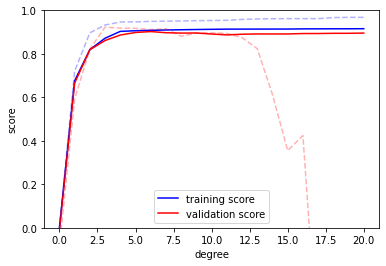

In [19]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            param_name='polynomialfeatures__degree', 
                                            param_range=degree, 
                                            cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

With a larger dataset, we do not seem to overfit (solid curves).

In general:  

- A model of a given complexity will overfit a small dataset: this means the training score will be relatively high, while the validation score will be relatively low.
- A model of a given complexity will underfit a large dataset: this means that the training score will decrease, but the validation score will increase.
- A model will never, except by chance, give a better score to the validation set than the training set: this means the curves should keep getting closer together but never cross.

### Learning Curves

![](05.03-learning-curve.png)

So, if we have high variance, we might need to add more data.

### Learning curves in Scikit-learn 
`learning_curve()` provides a convienent we to sweep different amounts of training data in a cross-validation evaluation of a model of a given complexity.

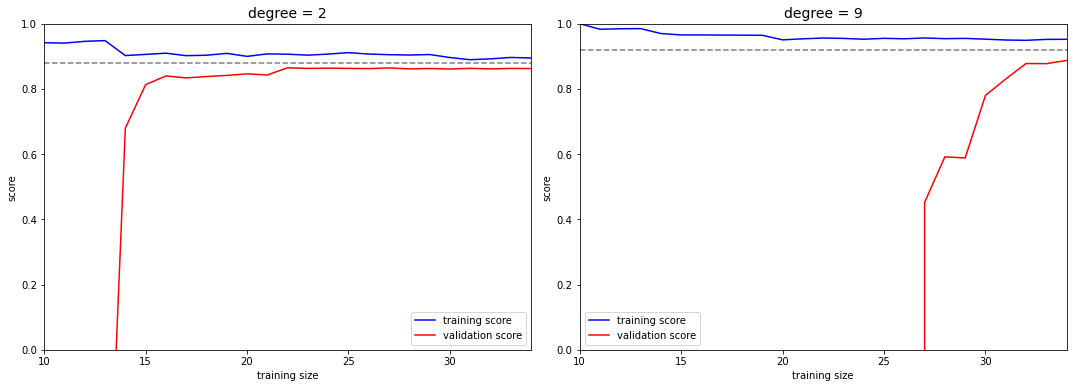

In [20]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')